In [1]:
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.experimental_models.snn_delay_prun import P_DelaySNN
from snn_delays.utils.train_utils import train, get_device, propagate_batch, to_plot
from snn_delays.utils.test_behavior import tb_addtask
from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'addtask_03_2025'

dataset = 'addtask_episodic'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3
#dataset_dict["time_ms"] = 50

In [3]:
structure = (48, 2)

# snn = P_DelaySNN(dataset_dict, structure=structure, connection_type='f', delay=(50,1), delay_type='h', delay_mask='random', n_pruned_delays=3,
#            reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

# snn.set_network()
# snn.use_amp = False
# snn.model_name = f'addask_d_tt' + '_st'
# snn.input2spike_th = None
# snn.num_train_samples = batch_size

# snn_rnnd = P_DelaySNN(dataset_dict, structure=structure, connection_type='r', delay=(50,1), delay_type='h', delay_mask='random', n_pruned_delays=1,
#            reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

# snn_rnnd.set_network()
# snn_rnnd.use_amp = False
# snn_rnnd.model_name = f'addask_rnnd_tt' + '_st'
# snn_rnnd.input2spike_th = None
# snn_rnnd.num_train_samples = batch_size


snn_mf = SNN(dataset_dict, structure=structure, connection_type='mf', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_mf.multi_proj = 3

snn_mf.set_network()
snn_mf.use_amp = False
snn_mf.model_name = f'addask_mf_tt' + '_st'
snn_mf.input2spike_th = None
snn_mf.num_train_samples = batch_size


snn_rnn = SNN(dataset_dict, structure=structure, connection_type='r', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_rnn.set_network()
snn_rnn.use_amp = False
snn_rnn.model_name = f'addask_rnn_tt' + '_st'
snn_rnn.input2spike_th = None
snn_rnn.num_train_samples = batch_size



[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407


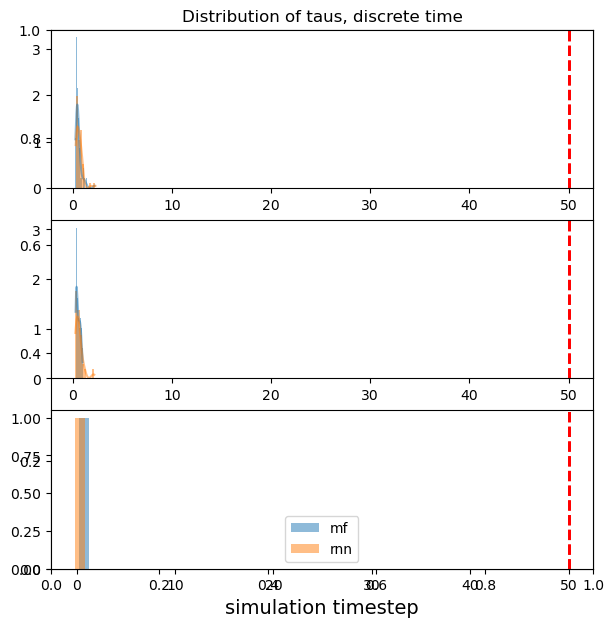

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot_taus(snn_mf, label='mf')
plot_taus(snn_rnn, label='rnn')
plt.legend()

In [5]:
train(snn_mf, train_loader, test_loader, 1e-3, 5000, lr_tau=0.01, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\addtask_03_2025
Mean Error: 0.0002684344945009798% 
--------------------------


In [6]:
train(snn_rnn, train_loader, test_loader, 1e-3, 5000, lr_tau=0.01, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\addtask_03_2025
Mean Error: 0.0014684076886624098% 
--------------------------


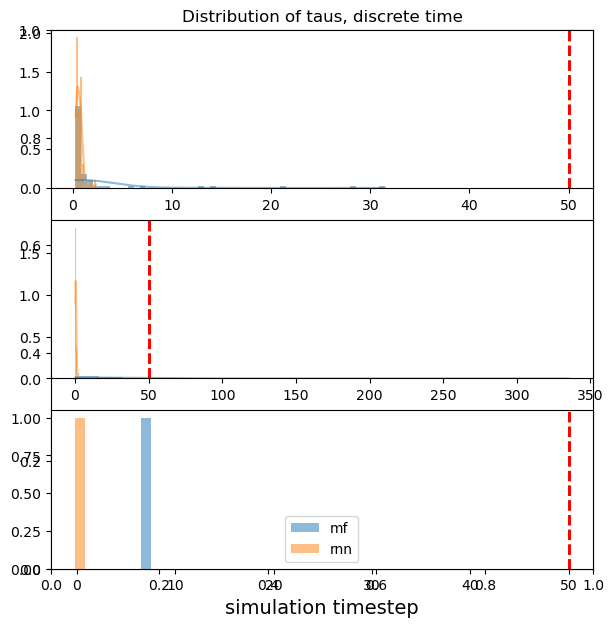

In [7]:
plt.figure(figsize=(7,7))
plot_taus(snn_mf, label='mf')
plot_taus(snn_rnn, label='rnn')
plt.legend()

Text(0.5, 1.0, 'train loss')

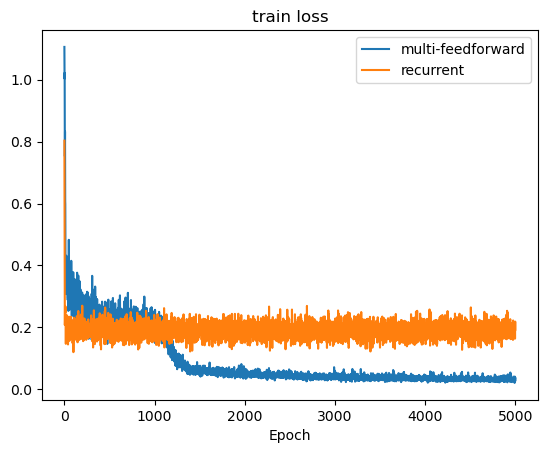

In [8]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
#plt.title(f'loss error = {loss_error}')

#plt.ylim(0, loss_error)
plt.title('train loss')

In [9]:
_, labels_mf = propagate_batch(snn_mf, test_loader)
_, labels_rnn = propagate_batch(snn_rnn, test_loader)

In [10]:
ref_mf = labels_mf[:,:int(0.1*time_window),0].T.cpu().numpy()
out_mf = snn_mf.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window),0].T.cpu().numpy()
out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

-0.059169997
0.033384055


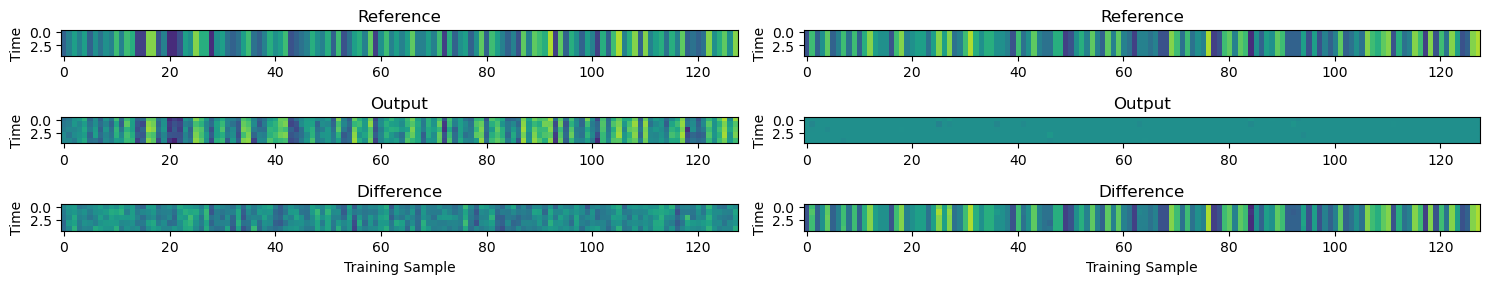

In [11]:
from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)
fig, axes = plt.subplots(3, 2, figsize=(15, 3))  # 3 rows, 3 columns

plot_add_task(out_mf, ref_mf, axes[:, 0])  # Second column
plot_add_task(out_rnn, ref_rnn, axes[:, 1])  # Third column

plt.tight_layout()
plt.show()

<Axes: xlabel='Index', ylabel='Value'>

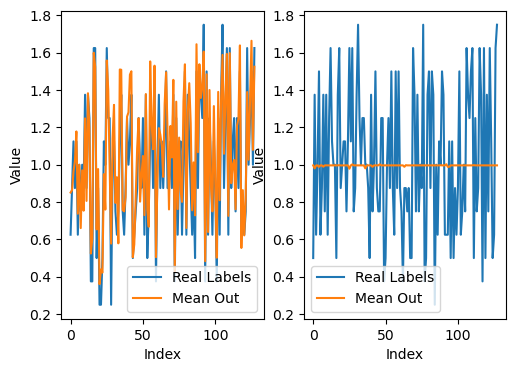

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(141)
plot_add_task2(out_mf, labels_mf)
plt.subplot(142)
plot_add_task2(out_rnn, labels_rnn)

<Axes: title={'center': 'output'}, xlabel='training sample', ylabel='time'>

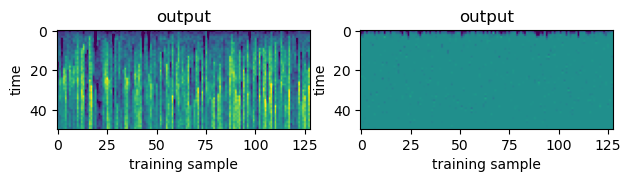

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(141)
plot_add_task3(snn_mf)
plt.subplot(142)
plot_add_task3(snn_rnn)

In [14]:
def propagate_batch_multiple(data_loader, *snns):
    
    '''
    make first channel of input zero
    '''

    for images, labels in data_loader:        
        # Propagate the modified input through each SNN
        for snn in snns:
            snn.propagate(images, labels)
        break

    #return images, labels

propagate_batch_multiple(test_loader, snn_mf, snn_rnn)

In [15]:
def visualize_activity(snn, layer, neuron=None, sample=None, threshold=False):
    """
    Function to visualize a single neuron's activity in the snn's layer
    of choice during the time that a sample of the batch is being processed.
    The membrane potential, the spikes and the reference threshold voltage
    are represented.

    :param snn: The neural network whose neuron activity will be plotted.
    :param layer: The layer of the network whose neuron activity will be
    plotted.
    :param neuron: Neuron of the layer whose activity is plotted.
    :param sample: Sample of the batch through which the activity is plotted.
    """

    # Check debug mode
    assert snn.debug == True, \
        "[ERROR]: Debug mode and at least one batch propagation are needed."

    # Take the number of neurons in the layer
    num_neurons = snn.spike_state[layer].shape[-1]

    # Pick a random neuron or sample the batch if some of them are not defined
    if sample is None:
        sample = np.random.randint(snn.batch_size)
    if neuron is None:
        neuron = np.random.randint(num_neurons)

    # Get spike state and threshold
    spk = snn.spike_state[layer][:,sample,neuron]
    evt_spk = spk.cpu().detach().numpy().nonzero()
    th_spk = snn.thresh * np.ones(len(evt_spk[0]))

    # Get membrane potential
    if layer != 'input':
        mem = snn.mem_state[layer][:,sample,neuron]
        mem = mem.cpu().detach().numpy()
    else:
        mem = np.zeros(snn.win,)

    # Plot
    if threshold:
        plt.hlines(snn.thresh, 0, snn.win, 'g', 'dashed', label='threshold')
    plt.plot(mem, label='membrane potential')
    # plt.eventplot(spk.cpu().detach().numpy().nonzero())
    plt.scatter(evt_spk, th_spk, c='k', marker=10, label = 'spikes')
    #plt.title('Dynamics of neuron = ' + str(neuron) +
    #          ' of the layer ' + str(layer))
    plt.ylabel('Memb. potential (mV)')
    plt.xlabel('Time (ms)')
    plt.legend()

    return plt.gca()

import torch

def plot_add_task4(snn, N):
    #N = np.random.randint(snn.batch_size)
    reference = torch.sum(snn.spike_state['input'][:,N,1]* snn.spike_state['input'][:,N,0]).item()
    visualize_activity(snn, 'output', sample=N)
    plt.plot(snn.spike_state['input'][:,N,1].cpu().numpy())
    plt.axhline(y=reference, color='r', linestyle='--')
    plt.axvspan(0.9*snn.win,snn.win, color='gray', alpha=0.5)

    return plt.gca()

<Axes: xlabel='Time (ms)', ylabel='Memb. potential (mV)'>

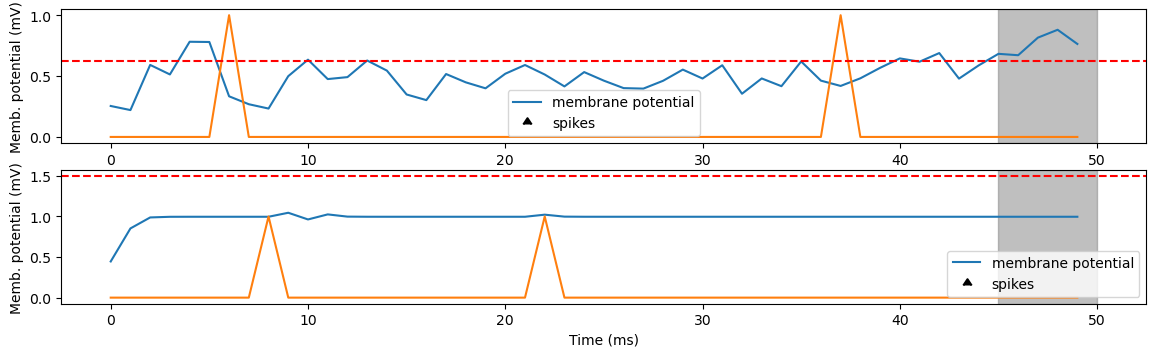

In [22]:
sample_number = 4

plt.figure(figsize=(14, 8))
plt.subplot(411)
plot_add_task4(snn_mf, sample_number)
plt.subplot(412)
plot_add_task4(snn_rnn, sample_number)


In [17]:
import torch
def get_errors_per_lapse(snn, num_trials):

    errors_per_lapse = [ [] for x in range(int(0.8*snn.win))]

    for trial in range(num_trials):

        _, labels = propagate_batch(snn, test_loader)
        ref = labels[:,:5,0].T.cpu().numpy()
        out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

        input_times = snn.spike_state['input'][:,:,1]

        outs = np.mean(out, axis=0)
        refs = np.mean(ref, axis=0)

        for sample in range(input_times.shape[1]):
            spike_times = torch.where(input_times[:, sample] == 1)[0]  # Get spike times
            dif = (spike_times[1] - spike_times[0]).item()
            errors_per_lapse[dif].append(abs(outs[sample]-refs[sample]))
    
    return errors_per_lapse


In [18]:
errors_mf = get_errors_per_lapse(snn_mf, 100)
errors_rnn = get_errors_per_lapse(snn_rnn, 100)

In [19]:
def plot_errors(errors, label='Mean loss', linestyle='-'):

    # Example data: replace `nested_loss_lists` with your actual data
    #nested_loss_lists = tstloss_d['f_d_2l_hm_ft']

    # Ensure all lists have the same length and epoch indices
    #epochs = [entry[0] for entry in nested_loss_lists[0]]  # Epochs
    times = range(int(0.8*time_window))
    #all_losses = [np.array([entry[1] for entry in lst]) for lst in nested_loss_lists]

    mean_losses = np.array([np.mean(err) for err in errors])
    std_losses = np.array([np.std(err) for err in errors])

    # # Calculate average and standard deviation
    # mean_losses = np.mean(all_losses, axis=0)
    # std_losses = np.std(all_losses, axis=0)

    # Plot the average loss curve with error bars
    #plt.figure(figsize=(10, 6))
    plt.plot(times, mean_losses, label=label, linestyle=linestyle)
    #plt.fill_between(epochs, mean_losses - std_losses, mean_losses + std_losses, color=color, alpha=0.2, label='±1 Std Dev')
    plt.fill_between(times, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
    #plt.title("Average Loss Curve")
    plt.xlabel("Interval")
    plt.ylabel("Absolute error")
    plt.legend()
    plt.grid(True)
    
    return plt.gca()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: xlabel='Interval', ylabel='Absolute error'>

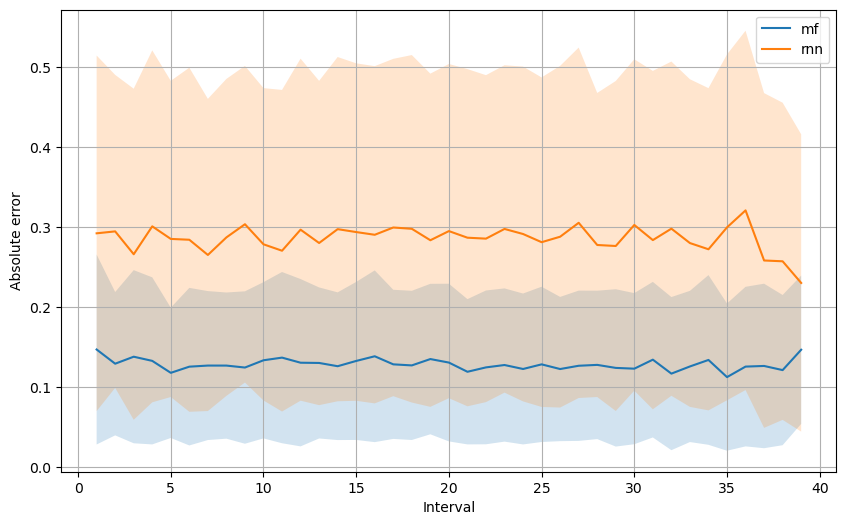

In [20]:
plt.figure(figsize=(10, 6))
plot_errors(errors_mf, 'mf')
plot_errors(errors_rnn, 'rnn')